This project aims to price an out-performance option using Monte Carlo simulation.    

Out-performance option payoffs depends on the prices of multiple assets. Assume that under risk-neutral measure,the prices of these underlying assets are all geometric Browinan Motion.

$$S_T^{(i)}=S_0^{(i)}e^{(r-\frac{1}{2}\sigma^{2})T+\sigma_iW_T^{(i)}}$$

for an out-performance option, the payoff is:

$$ (max(S_T^{(1)},...,S_T^{(d)})-K)^+ $$

in order to use monte-carlo simulation to price the option, we need to first determine the variance-covariance matrix. We use EWMA(0.94) model in the historical data to do that.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def read_file(file_name):
    df=pd.read_excel(file_name,header=0,index_col=0,parse_dates=True,usecols=list(range(8)))
    return df
aapl=read_file('aapl.xlsx')
msft=read_file('msft.xlsx')
goog=read_file('goog.xlsx')
amzn=read_file('amzn.xlsx')
amzn=amzn.iloc[::-1]   # data cleaning
aapl=aapl.iloc[1:,:]   # remove Nan values
msft=msft.iloc[1:,:]
goog=goog.iloc[1:,:]
amzn=amzn.iloc[1:,:]
aapl.head()

,收盘,净值,涨跌幅,开盘,低值,高值,成交量
交易日期,,,,,,,
2021-03-02,125.12,-2.67,-0.020894,128.41,125.01,128.720,102260945
2021-03-03,122.06,-3.06,-0.024457,124.81,121.84,125.710,112966340
2021-03-04,120.13,-1.93,-0.015812,121.75,118.62,123.600,178154975
2021-03-05,121.42,1.29,0.010738,120.98,117.57,121.935,153766601
2021-03-08,116.36,-5.06,-0.041674,120.93,116.21,121.000,154376610


In [3]:
def ewma_var(logrtn:pd.Series)->pd.Series:
    '''
    Calculate the EWMA sigma of a series of log returns
    '''
    sigma=pd.Series(index=logrtn.index,dtype='float64')
    sigma[0]=logrtn[0]**2
    for i in range(1,len(logrtn)):
        sigma[i]=0.94*sigma[i-1]+0.06*logrtn[i]**2
    return sigma

def add_var(df:pd.DataFrame)->pd.DataFrame:
    '''
    Add the EWMA sigma to the dataframe
    '''
    df['EWMA_var']=ewma_var(df['涨跌幅'])
    return df

In [4]:
aapl=add_var(aapl)
msft=add_var(msft)
goog=add_var(goog)
amzn=add_var(amzn)
amzn.head()

,收盘,净值,涨跌幅,开盘,低值,高值,成交量,EWMA_var
交易日期,,,,,,,,
2021-03-02,3094.53,-51.61,-0.016404,3143.47,3087.1201,3163.520,2595762,0.000269
2021-03-03,3005.00,-89.53,-0.028932,3081.18,2995.0000,3107.775,3988725,0.000303
2021-03-04,2977.57,-27.43,-0.009128,3012.00,2945.4300,3058.130,5481578,0.000290
2021-03-05,3000.46,22.89,0.007687,3005.00,2881.0001,3009.000,5388551,0.000276
2021-03-08,2951.95,-48.51,-0.016168,3015.00,2951.3100,3064.590,4185008,0.000275


In [5]:
var_mtx=pd.DataFrame(index=aapl.index,columns=['aapl','msft','goog','amzn'])
var_mtx['aapl']=aapl['EWMA_var']
var_mtx['msft']=msft['EWMA_var']
var_mtx['goog']=goog['EWMA_var']
var_mtx['amzn']=amzn['EWMA_var']
var_mtx.head()

,aapl,msft,goog,amzn
交易日期,,,,
2021-03-02,0.000437,0.000168,0.000007,0.000269
2021-03-03,0.000446,0.000201,0.000041,0.000303
2021-03-04,0.000434,0.000190,0.000045,0.000290
2021-03-05,0.000415,0.000206,0.000093,0.000276
2021-03-08,0.000495,0.000214,0.000184,0.000275


In [6]:
corr=np.corrcoef(var_mtx.T)
cholesky_decomp=np.linalg.cholesky(corr)
cholesky_decomp=np.matrix(cholesky_decomp)
cholesky_decomp

matrix([[ 1.        ,  0.        ,  0.        ,  0.        ],
        [ 0.53829778,  0.84275471,  0.        ,  0.        ],
        [ 0.40938295,  0.65155584,  0.63865529,  0.        ],
        [ 0.86026814,  0.12565265, -0.21969124,  0.44258999]])

Next we construct risk-free interest rate term structure from OIS rate.

In [7]:
OIS=pd.read_excel('interest_rate.xlsx',header=0,index_col=0,parse_dates=True)
OIS_rate=pd.DataFrame(OIS['RATE/PRICE']/100)
OIS_rate.index.name=None
OIS_rate.columns=['rfr_APR5']
OIS_rate

,rfr_APR5
2022-04-06,0.003351
2022-04-07,0.003368
2022-04-14,0.003474
2022-04-21,0.003512
2022-05-09,0.003780
2022-06-07,0.005670
2022-07-07,0.007560


In [8]:
def rfr(t1:str,t2:str)->float:
    '''
    Calculate the risk-free rate between t1 and t2
    '''
    t0=pd.to_datetime('2022-04-05')
    t1=pd.to_datetime(t1)
    t2=pd.to_datetime(t2)
    t1_t0=(pd.to_datetime(t1)-t0).days/365
    t2_t0=(pd.to_datetime(t2)-t0).days/365
    delta_t=t2_t0-t1_t0
    return (OIS_rate['rfr_APR5'][t2]*t2_t0-OIS_rate['rfr_APR5'][t1]*t1_t0)/delta_t

def delta_t(t:str)->float:
    '''
    Calculate the delta t
    '''
    t0=pd.to_datetime('2022-04-05')
    t=pd.to_datetime(t)
    t_t0=(t-t0).days/365
    return t_t0

In [9]:
term=pd.date_range(start='2022-04-06',end='2022-07-07',freq='B')
rfr_df=pd.DataFrame(index=term,dtype='float64',columns=['rfr_APR5','df'])
rfr_df.update(OIS_rate)

In [10]:
def add_rfr(pillar_date1,pillar_date2):
    date1=pd.to_datetime(pillar_date1)
    date2=pd.to_datetime(pillar_date2)
    for i in pd.date_range(date1+pd.to_timedelta('1 days'),date2-pd.to_timedelta('1 days'),freq='B'):
        rfr1=rfr_df['rfr_APR5'][pillar_date1]   # pillar1的OIS
        rfr2=rfr_df['rfr_APR5'][pillar_date2]
        rfr_m=rfr(pillar_date1,pillar_date2)
        rfr_df.loc[i]['rfr_APR5']=rfr_m
        rfr_df.loc[i]['df']=np.exp(-rfr1*delta_t(pillar_date1)-rfr_m*(delta_t(i)-delta_t(pillar_date1)))
        

In [11]:
add_rfr('2022-04-07','2022-04-14')
add_rfr('2022-04-14','2022-04-21')
add_rfr('2022-04-21','2022-05-09')
add_rfr('2022-05-09','2022-06-07')
add_rfr('2022-06-07','2022-07-07')
rfr_df['df']['2022-04-06']=np.exp(-rfr_df['rfr_APR5']['2022-04-06']*delta_t('2022-04-06'))
rfr_df['df']['2022-04-07']=np.exp(-rfr_df['rfr_APR5']['2022-04-07']*delta_t('2022-04-07'))
rfr_df['df']['2022-04-14']=np.exp(-rfr_df['rfr_APR5']['2022-04-14']*delta_t('2022-04-14'))
rfr_df['df']['2022-04-21']=np.exp(-rfr_df['rfr_APR5']['2022-04-21']*delta_t('2022-04-21'))
rfr_df['df']['2022-05-09']=np.exp(-rfr_df['rfr_APR5']['2022-05-09']*delta_t('2022-05-09'))
rfr_df['df']['2022-06-07']=np.exp(-rfr_df['rfr_APR5']['2022-06-07']*delta_t('2022-06-07'))
rfr_df['df']['2022-07-07']=np.exp(-rfr_df['rfr_APR5']['2022-07-07']*delta_t('2022-07-07'))
rfr_df



,rfr_APR5,df
2022-04-06,0.003351,0.999991
2022-04-07,0.003368,0.999982
2022-04-08,0.003504,0.999972
2022-04-11,0.003504,0.999943
2022-04-12,0.003504,0.999934
...,...,...
2022-07-01,0.011529,0.998265
2022-07-04,0.011529,0.998170
2022-07-05,0.011529,0.998139
2022-07-06,0.011529,0.998107


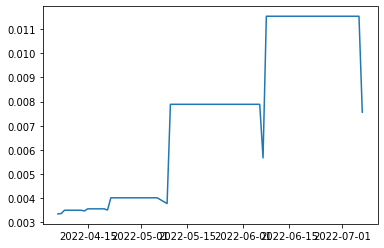

In [72]:
plt.plot(rfr_df['rfr'])
plt.show()

In [64]:
rng=np.random.default_rng(21)

ST_S0=[]  # 存放ST/S0
for i in range(4):
    ewma_sigma=var_mtx.iloc[-1,i]
    sigma_sum=ewma_sigma
    root_sigma_sum=np.sqrt(ewma_sigma)
    Si1_S0=1
    for m in rfr_df['df'].index:
        Z=rng.standard_normal((4,1))
        Y=np.dot(cholesky_decomp,Z)
        r_barT=-np.log(rfr_df['df'][m])
        Si_S0=np.exp(r_barT-1/2*sigma_sum+root_sigma_sum*Y[i,0])   
        ewma_sigma=0.94*ewma_sigma+0.06*np.log(Si_S0/Si1_S0)**2
        Si1_S0=Si_S0
        root_sigma_sum+=np.sqrt(ewma_sigma)  # 问题在于方差的和与rbarT的日期长度不对应，应该多减去一些休息日方差
        sigma_sum+=ewma_sigma
    ST_S0.append(Si_S0)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8724\864188805.py:14: RuntimeWarning: divide by zero encountered in log
  ewma_sigma=0.94*ewma_sigma+0.06*np.log(Si_S0/Si1_S0)**2
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8724\864188805.py:13: RuntimeWarning: invalid value encountered in double_scalars
  Si_S0=np.exp(r_barT-1/2*sigma_sum+(np.log(ewma_sigma)+root_sigma_sum)*Y[i,0])
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8724\864188805.py:14: RuntimeWarning: invalid value encountered in double_scalars
  ewma_sigma=0.94*ewma_sigma+0.06*np.log(Si_S0/Si1_S0)**2


In [63]:
ST_S0

[nan, nan, nan, nan]

In [71]:
Y[1,0]

-1.0361258194954805